This is almost the same file of the previous one, but with reduced units (Interesting to compare with actual data)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Reduced units
T_star = 1.5  # Reduced temperature
n_star = 0.9  # Reduced density
num_molecules = 84

# Calculate box size for the given reduced density in 2D
box_area = num_molecules / n_star
box_size = np.sqrt(box_area)  # Since area = length^2 in 2D

# Maximum displacement in a single step
max_displacement = 0.2  

# Initialize positions in a 2D lattice
np.random.seed(0)
positions = np.random.rand(num_molecules, 2) * box_size

def lennard_jones_potential(r):
    """ Calculate Lennard-Jones potential for a distance r in reduced units """
    r6 = (1 / r)**6  # sigma is 1 in reduced units
    r12 = r6**2
    return 4 * (r12 - r6)  # epsilon is 1 in reduced units

def total_potential_energy(positions):
    # Compute all pairwise distances using broadcasting
    diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
    diff = diff - np.round(diff / box_size) * box_size  # Periodic boundary conditions
    distances = np.sqrt(np.sum(diff**2, axis=-1))

    # Avoid division by zero and self-interactions
    np.fill_diagonal(distances, np.inf)
    
    # Get only the upper triangle of the distance matrix
    distances = distances[np.triu_indices(num_molecules, k=1)]

    # Vectorized Lennard-Jones potential calculation
    return np.sum(lennard_jones_potential(distances)) 

def metropolis_step(positions, total_energy):
    """ Perform one step of the Metropolis algorithm """
    # Choose a random molecule
    molecule_idx = np.random.randint(num_molecules)
    old_position = positions[molecule_idx].copy()

    # Move the molecule to a new position
    displacement = (np.random.rand(2) - 0.5) * max_displacement
    positions[molecule_idx] += displacement

    # Apply periodic boundary conditions
    positions[molecule_idx] %= box_size

    # Calculate the energy change
    new_energy = total_potential_energy(positions)
    delta_energy = new_energy - total_energy

    # Metropolis criterion
    if delta_energy > 0 and -delta_energy / T_star < np.log(np.random.rand()):
        # Reject the move, revert to the old position
        positions[molecule_idx] = old_position
    else:
        # Accept the move, update total energy
        total_energy = new_energy

    return positions, total_energy

# Initialize the total energy
total_energy = total_potential_energy(positions)
total_energy_history = [total_energy]

# Number of steps for the simulation
num_steps = 1000

# Perform the simulation
positions_history = [positions.copy()]
for step in range(1, num_steps * num_molecules):
    positions, total_energy = metropolis_step(positions, total_energy)
    positions_history.append(positions.copy())
    if (step % num_molecules == 0):
        total_energy_history.append(total_energy)

1000


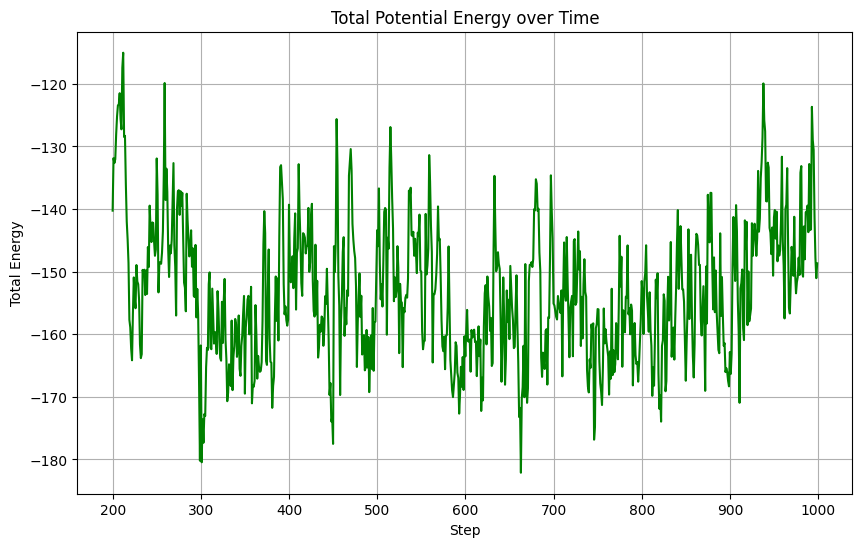

In [2]:
print(len(total_energy_history))
# Plotting the total energy over time
plt.figure(figsize=(10, 6))
plt.plot(range(200, num_steps), total_energy_history[200:], color='green')
plt.title("Total Potential Energy over Time")
plt.xlabel("Step")
plt.ylabel("Total Energy")
plt.grid(True)
plt.show()


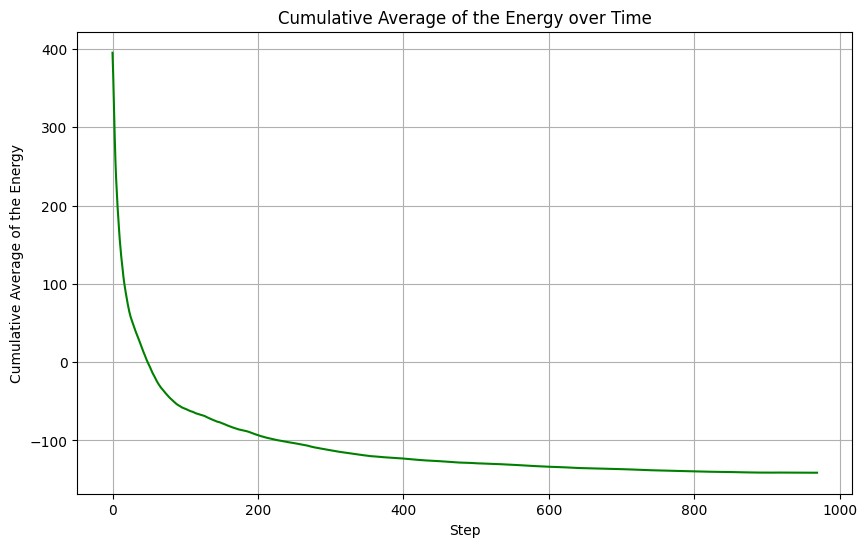

In [3]:
# Cumulative Average of the energy step by step
cum_avg_energy = np.cumsum(total_energy_history[30:]) / (np.arange(len(total_energy_history[30:])) + 1)

# Plotting the cumulative average of the energy over time
plt.figure(figsize=(10, 6))
plt.plot(cum_avg_energy, color='green')
plt.title("Cumulative Average of the Energy over Time")
plt.xlabel("Step")
plt.ylabel("Cumulative Average of the Energy")
plt.grid(True)
plt.show()

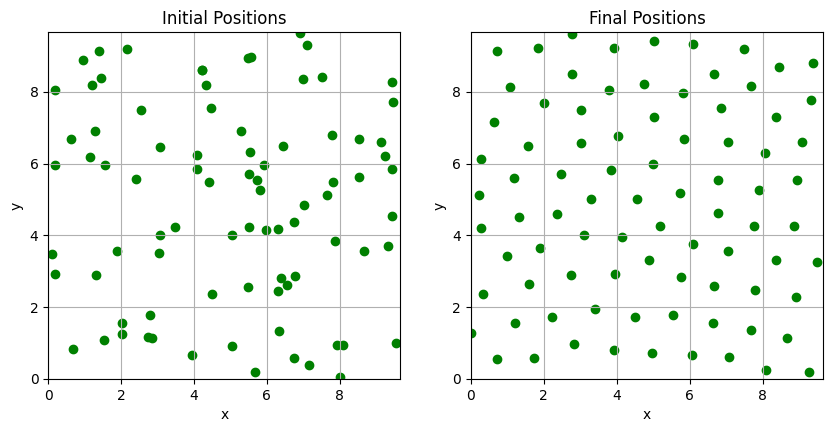

In [4]:
# Plot positions initial and final in two plots but in the same figure
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)
plt.scatter(positions_history[0][:, 0], positions_history[0][:, 1], color='green')
plt.title("Initial Positions")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.grid(True)
plt.subplot(1, 2, 2)
plt.scatter(positions_history[-1][:, 0], positions_history[-1][:, 1], color='green')
plt.title("Final Positions")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, box_size)
plt.ylim(0, box_size)
plt.grid(True)
plt.show()

In [5]:
theoretical_rdf = lambda r_star, T_star, p_star : 1 + (r_star)**(-2) * np.exp()

[       nan 0.         0.         0.         0.         0.
 0.         0.         0.         3.76636985 8.74551079 5.12662078
 2.04796361 1.20345546 0.83013866 0.76833945 0.67529834 0.95006354
 1.6320936  1.74651056 1.67791777 1.84475258 1.34468742 0.92272501
 0.88274293 0.61828727 0.55659815 0.75327397 1.02470241 0.94315992
 1.07341541 0.80422382 0.90370808 0.74704857 0.73014142 0.56449429
 0.53356906 0.49768905 0.74649242 0.72207327 0.62286341]


/var/folders/bd/rn8my1zs30g5ml3258f07ft80000gn/T/ipykernel_96127/1560465130.py:20: RuntimeWarning: invalid value encountered in divide
  rdf = hist / (4 * np.pi * bin_edges[:-1]**2 * bin_width * rho * N)


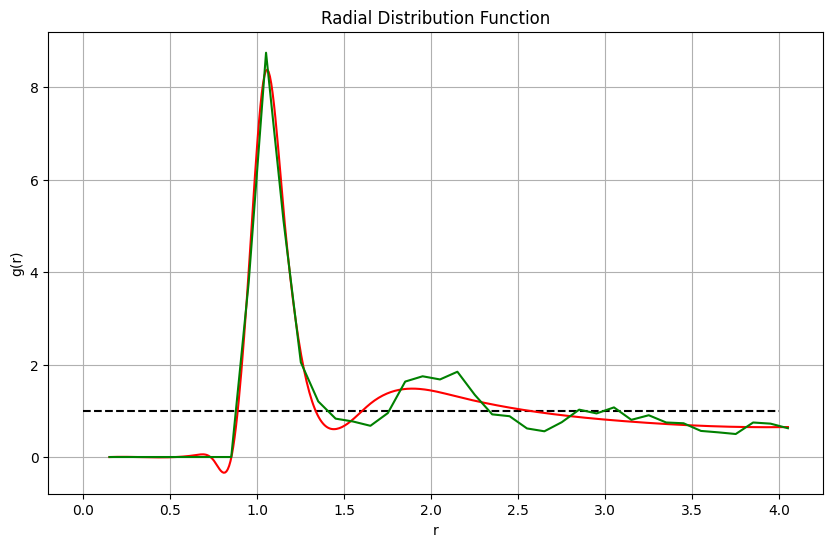

In [36]:
from scipy.interpolate import UnivariateSpline

def compute_rdf(positions, L, N, bin_width, max_range=box_size/2):
    # Compute distances considering periodic boundary conditions
    def compute_distances(positions):
        # Compute all pairwise distances using broadcasting
        diff = positions[:, np.newaxis, :] - positions[np.newaxis, :, :]
        diff = diff - np.round(diff / L) * L
        distances = np.sqrt(np.sum(diff**2, axis=-1))
        return distances[np.triu_indices(N, k=1)]

    distances = compute_distances(positions)

    # Histogram
    bins = np.arange(0, max_range, bin_width)
    hist, bin_edges = np.histogram(distances, bins=bins, density=False)

    # Normalize RDF
    rho = N / L**3  # Number density
    rdf = hist / (4 * np.pi * bin_edges[:-1]**2 * bin_width * rho * N)

    # Compute bin centers
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    return bin_centers, rdf

bin_centers, rdf = compute_rdf(positions_history[-1], box_size, num_molecules, 0.1, 4.2)
print(rdf)

spline = UnivariateSpline(bin_centers[1:], rdf[1:])
spline.set_smoothing_factor(2.0)

# Generate a smooth curve for plotting
x_fit = np.linspace(bin_centers[1], bin_centers[-1], 500)
y_spline = spline(x_fit)

# Plotting the radial distribution function
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 4, 500), np.ones(500), color='black', linestyle='dashed')
plt.plot(x_fit, y_spline, color='red')
plt.plot(bin_centers, rdf, color='green')
plt.title("Radial Distribution Function")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.grid(True)
plt.show()


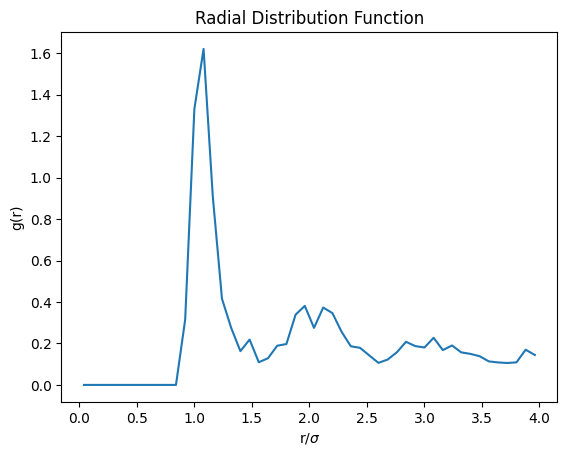

In [7]:
def compute_rdf(positions, num_bins=50, max_radius=box_size/2):
    distances = []
    for i in range(num_molecules):
        for j in range(i + 1, num_molecules):
            diff = positions[i] - positions[j]
            diff -= np.round(diff / box_size) * box_size  # Apply periodic boundary conditions
            distances.append(np.linalg.norm(diff))

    hist, bin_edges = np.histogram(distances, bins=num_bins, range=(0, max_radius), density=False)
    radii = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Normalize histogram to get RDF
    normalization = (num_molecules * (num_molecules - 1) / 2) * (4 * np.pi * radii**2) * (bin_edges[1] - bin_edges[0]) / box_size**2
    rdf = hist / normalization

    return radii, rdf

final_positions = positions_history[-1]
radii, rdf = compute_rdf(final_positions, num_bins=50, max_radius=4)

plt.plot(radii, rdf, label='Simulation')
plt.xlabel('r/$\sigma$')
plt.ylabel('g(r)')
plt.title('Radial Distribution Function')
plt.show()


In [8]:
# Compute the distance between all pairs of particles
distances = np.zeros((num_molecules, num_molecules))
for i in range(num_molecules):
    for j in range(i + 1, num_molecules):
        diff = final_positions[i] - final_positions[j]
        diff -= np.round(diff / box_size) * box_size  # Apply periodic boundary conditions
        distances[i, j] = np.linalg.norm(diff)
distances[distances == 0] = np.inf 

# Minimun distance between all pairs of particles
min_distance = np.min(distances)
print(min_distance)

0.9106045218097568


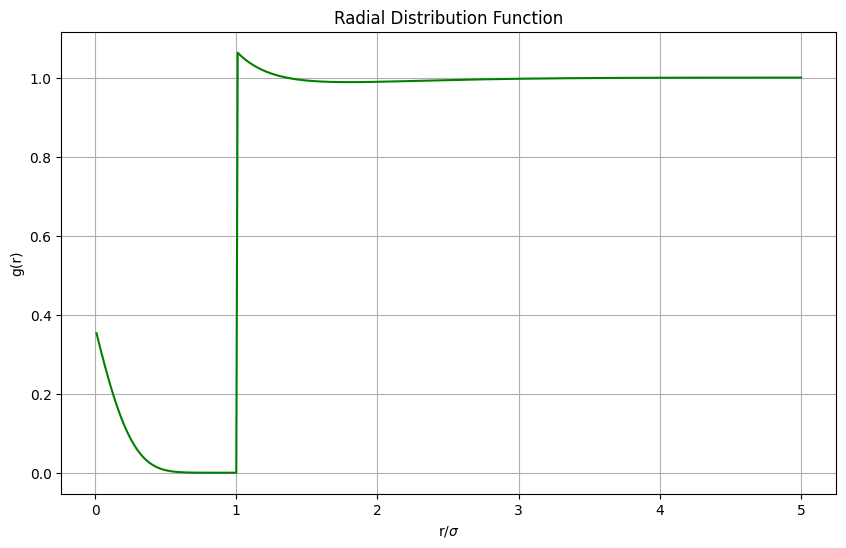

In [9]:
import numpy as np

def calculate_parameter(q_values, T_star, rho_star):
    # Generalized function to calculate each parameter based on the provided q_values
    # q_values is a list of the form [q1, q2, ..., q9]
    # T_star and rho_star are the reduced temperature and density, respectively
    return sum(q * (T_star ** i) * (rho_star ** (len(q_values) - i - 1)) for i, q in enumerate(q_values))

# Define the RDF function based on the given formula
def radial_distribution_function(r_star, T_star, q_star, parameters):
    a, b, c, d, g, h, k, l, m, n, s = parameters

    if r_star > 1:
        return 1 + (r_star ** -2) * np.exp(- (a * r_star + b)) * np.sin((c * r_star + d)) \
               + (r_star ** -2) * np.exp(- (g * r_star + h)) * np.cos((k * r_star + l))
    else:
        return s * np.exp(- (m * r_star + n) ** 4)

# This is a placeholder for the adjustable parameters (a, b, c, d, g, h, k, l, m, n, s)
# In practice, these would be determined based on temperature and density
parameters = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 

# Example usage
r_stars = np.linspace(0.01, 5.0, 500)  # example value
T_star = 1.5  # example value
rho_star = 0.9  # example value
rdf_value = [radial_distribution_function(r_star, T_star, rho_star, parameters)for r_star in r_stars]

# Plotting the RDF
plt.figure(figsize=(10, 6))
plt.plot(r_stars, rdf_value, color='green')
plt.title("Radial Distribution Function")
plt.xlabel("r/$\sigma$")
plt.ylabel("g(r)")
plt.grid(True)
plt.show()
